In [12]:
import vnquant.data as dt
from vnquant import plot as pl

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# Trong file model.py
import sys
import os

from arima.utils import*
from arima import *

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from tqdm import tqdm

NameError: name '__init__' is not defined

In [7]:
stock= SelectedStock("VCB", "2020-01-01", "2023-01-01")
stock.data = stock.data.droplevel(level='Symbols', axis=1)

NameError: name 'SelectedStock' is not defined




Epoch 1/50

7/7 [==============================] - 5s 13ms/step - loss: 0.1782
Epoch 2/50
7/7 [==============================] - 0s 11ms/step - loss: 0.1127
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.1024
Epoch 4/50
7/7 [==============================] - 0s 15ms/step - loss: 0.1082
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.1019
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0989
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0972
Epoch 8/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0975
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0967
Epoch 10/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0959
Epoch 11/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0979
Epoch 12/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0976
Epoch 13/50
7/7 [==============================] - 0s 23m

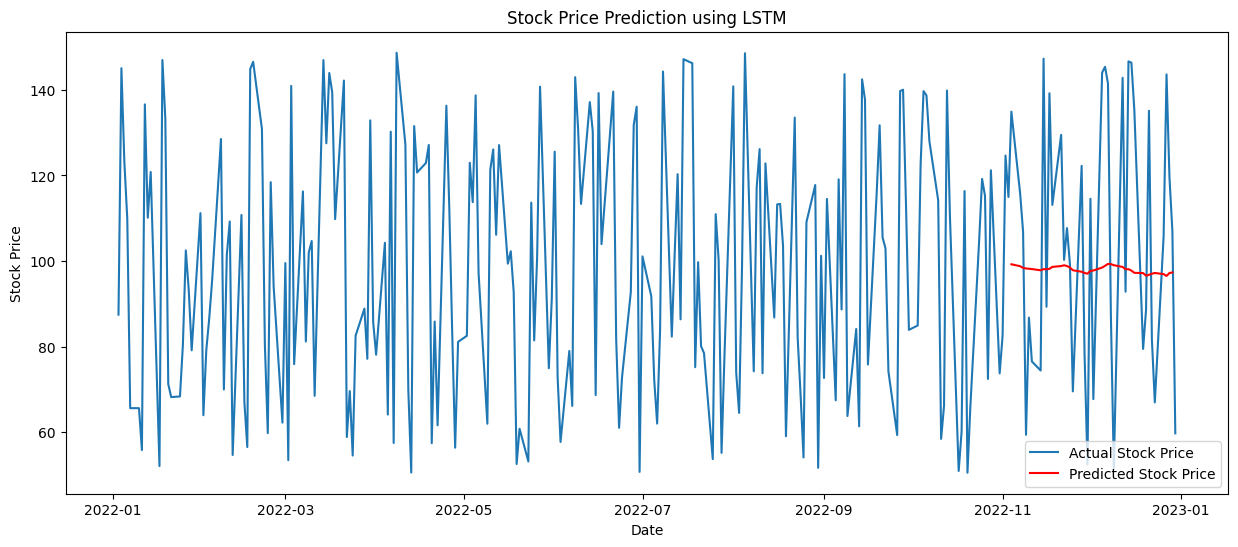

In [2]:


# Đọc dữ liệu giá cổ phiếu (đảm bảo có cột 'Date' và 'Close')
# df = pd.read_csv('du_lieu_co_phieu.csv')
# df = df[['Date', 'Close']]
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)

# Ví dụ với dữ liệu giả định
np.random.seed(42)
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='B')
df = pd.DataFrame(date_rng, columns=['date'])
df['stock_price'] = np.random.uniform(50, 150, size=(len(date_rng),))

# Chuẩn bị dữ liệu
data = df['stock_price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Chia dữ liệu thành bộ dữ liệu huấn luyện và kiểm tra
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

# Chuyển dữ liệu thành dãy thời gian và dãy kết quả
def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 10
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Reshape dữ liệu để phù hợp với đầu vào của LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Dự đoán giá cổ phiếu trên tập kiểm tra
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Chuyển kết quả dự đoán thành DataFrame để so sánh với giá thực tế
df_result = df.iloc[train_size + time_steps + 1: len(df)-1, :].copy()
df_result['predicted_price'] = predictions[:-1]

# Trực quan hóa kết quả
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['stock_price'], label='Actual Stock Price')
plt.plot(df_result['date'], df_result['predicted_price'], label='Predicted Stock Price', color='red')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [4]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# Ví dụ với dữ liệu giả định
np.random.seed(42)
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='B')
df = pd.DataFrame(date_rng, columns=['date'])
df['stock_price'] = np.random.uniform(50, 150, size=(len(date_rng),))
df['volume'] = np.random.uniform(10000, 50000, size=(len(date_rng),))
df['feature_1'] = np.random.uniform(0, 1, size=(len(date_rng),))
df['feature_2'] = np.random.uniform(0, 1, size=(len(date_rng),))

# Chuẩn bị dữ liệu
data = df[['stock_price', 'volume', 'feature_1', 'feature_2']].values

# Chia thành biến độc lập và biến phụ thuộc
X = data[:, 1:]  # Biến độc lập là volume, feature_1, feature_2
y = data[:, 0]   # Biến phụ thuộc là stock_price

# Chia thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sử dụng RFE với mô hình Linear Regression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=2)  # Chọn 2 biến
fit = rfe.fit(X_train, y_train)

# In thông tin về biến được chọn
print("Num Features: ", fit.n_features_)
print("Selected Features: ", fit.support_)
print("Feature Ranking: ", fit.ranking_)

# Dự đoán giá cổ phiếu trên tập kiểm tra với các biến được chọn
y_pred = fit.predict(X_test)

# Đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Num Features:  2
Selected Features:  [False  True  True]
Feature Ranking:  [2 1 1]
Mean Squared Error: 900.8722972484759
